<a href="https://colab.research.google.com/github/swathi156/swathi156/blob/main/hypo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load dataset
df = pd.read_csv(r"/content/hypothyroid.csv")

# Data Preprocessing
df = df.replace('?', np.nan)
df = df.drop(['TBG', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured'], axis=1)
df['sex'] = df['sex'].map({'F': 0, 'M': 1})

binary_cols = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
               'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych']
for col in binary_cols:
    df[col] = df[col].map({'f': 0, 't': 1})

df = pd.get_dummies(df, columns=['referral_source'], drop_first=True)
df['Class'] = LabelEncoder().fit_transform(df['Class'])

# Handling Missing Values
df = df.fillna(df.median())

# Splitting Dataset
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to Create and Train ANN Models
def build_ann_model(layers, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for units in layers:
        model.add(Dense(units, activation=activation))
    model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output Layer
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

# Define Different ANN Models
models = {
    "MLP": build_ann_model([64, 32]),
    "FNN": build_ann_model([128, 64, 32]),
    "DNN": build_ann_model([256, 128, 64, 32])
}

# Train and Evaluate Models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    test_loss, test_acc = model.evaluate(X_test, y_test)
    results[name] = test_acc

# Display Results
print("\nModel Performance:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")


<ipython-input-3-ca804f17f6cc>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('?', np.nan)


TypeError: Cannot convert [['41' '23' '46' ... '74' '72' '64']
 ['1.3' '4.1' '0.98' ... '5.1' '0.7' '1']
 ['2.5' '2' nan ... '1.8' '2' '2.2']
 ['125' '102' '109' ... '112' '82' '99']
 ['1.14' nan '0.91' ... '1.07' '0.94' '1.07']
 ['109' nan '120' ... '105' '87' '92']] to numeric

In [2]:
from google.colab import files
uploaded = files.upload()


Saving hypothyroid.csv to hypothyroid.csv


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc,RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
pd.set_option('display.max_columns', None)
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
#Loading data as dataframe
#df = pd.read_csv(r"https://raw.githubusercontent.com/Sunita778/Thyroid-Disease-Detection/main/hypothyroid.csv")
df = pd.read_csv(r"/content/hypothyroid.csv")

In [6]:
#reading first 5 row of dataframe
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,negative


In [7]:
#Checking information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [8]:
#Create a copy for better practice
data = df.copy()

In [9]:
#Shape of the data
data.shape


(3772, 30)

In [10]:
# Display all Columns
data.columns


Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'Class'],
      dtype='object')

In [11]:
data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,288,2,70,2,242,2,147,2,235,1,1,5,4
top,59,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,?,t,?,t,?,t,?,t,?,f,?,other,negative
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,3535,3754,3738,3676,3771,3588,3403,369,3003,769,3541,231,3385,387,3387,385,3772,3772,2201,3481


In [12]:
#Checking for null values
data.isnull().sum()

,0
age,0
sex,0
on_thyroxine,0
query_on_thyroxine,0
on_antithyroid_medication,0
sick,0
pregnant,0
thyroid_surgery,0
I131_treatment,0
query_hypothyroid,0


In [13]:

data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'Class'],
      dtype='object')

In [14]:
#Checking for unique values in class column

data['Class'].unique()


array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [15]:
#

n = len(data[data['Class'] == 'secondary_hypothyroid'])
print("No of secondary_hypothyroid in Dataset:",n)

n = len(data[data['Class'] == 'primary_hypothyroid'])
print("No of primary_hypothyroid in Dataset:",n)

n = len(data[data['Class'] == 'compensated_hypothyroid'])
print("No of compensated_hypothyroid in Dataset:",n)

n = len(data[data['Class'] == 'negative'])
print("No of negative in Dataset:",n)

No of secondary_hypothyroid in Dataset: 2
No of primary_hypothyroid in Dataset: 95
No of compensated_hypothyroid in Dataset: 194
No of negative in Dataset: 3481


In [16]:
#For checking unique value of every column
for column in data.columns:
    print(column,'--->', (data[column].unique()))

age ---> ['41' '23' '46' '70' '18' '59' '80' '66' '68' '84' '67' '71' '28' '65'
 '42' '63' '51' '81' '54' '55' '60' '25' '73' '34' '78' '37' '85' '26'
 '58' '64' '44' '48' '61' '35' '83' '21' '87' '53' '77' '27' '69' '74'
 '38' '76' '45' '36' '22' '43' '72' '82' '31' '39' '49' '62' '57' '1' '50'
 '30' '29' '75' '19' '7' '79' '17' '24' '15' '32' '47' '16' '52' '33' '13'
 '10' '89' '56' '20' '90' '40' '88' '14' '86' '94' '12' '4' '11' '8' '5'
 '455' '2' '91' '6' '?' '93' '92']
sex ---> ['F' 'M' '?']
on_thyroxine ---> ['f' 't']
query_on_thyroxine ---> ['f' 't']
on_antithyroid_medication ---> ['f' 't']
sick ---> ['f' 't']
pregnant ---> ['f' 't']
thyroid_surgery ---> ['f' 't']
I131_treatment ---> ['f' 't']
query_hypothyroid ---> ['f' 't']
query_hyperthyroid ---> ['f' 't']
lithium ---> ['f' 't']
goitre ---> ['f' 't']
tumor ---> ['f' 't']
hypopituitary ---> ['f' 't']
psych ---> ['f' 't']
TSH_measured ---> ['t' 'f']
TSH ---> ['1.3' '4.1' '0.98' '0.16' '0.72' '0.03' '?' '2.2' '0.6' '2.4' '1.1' 

In [18]:
col_name = ['on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured']

for col in col_name:
    print(f"No.of 'f' and 't' values are in {col} column")
    print(f"No.of f value in {col} column : {len(data[data[col] == 'f'])}")
    print(f"No.of t value in {col} column : {len(data[data[col] == 't'])}", '\n', '---'*20)

No.of 'f' and 't' values are in on_thyroxine column
No.of f value in on_thyroxine column : 3308
No.of t value in on_thyroxine column : 464 
 ------------------------------------------------------------
No.of 'f' and 't' values are in query_on_thyroxine column
No.of f value in query_on_thyroxine column : 3722
No.of t value in query_on_thyroxine column : 50 
 ------------------------------------------------------------
No.of 'f' and 't' values are in on_antithyroid_medication column
No.of f value in on_antithyroid_medication column : 3729
No.of t value in on_antithyroid_medication column : 43 
 ------------------------------------------------------------
No.of 'f' and 't' values are in sick column
No.of f value in sick column : 3625
No.of t value in sick column : 147 
 ------------------------------------------------------------
No.of 'f' and 't' values are in pregnant column
No.of f value in pregnant column : 3719
No.of t value in pregnant column : 53 
 ---------------------------------

In [19]:
#Checking for '?' value in our data which are null values

data.isin(['?']).sum()

,0
age,1
sex,150
on_thyroxine,0
query_on_thyroxine,0
on_antithyroid_medication,0
sick,0
pregnant,0
thyroid_surgery,0
I131_treatment,0
query_hypothyroid,0


In [20]:
# we can see that for column 'TBG' all the values are missing. So we will drop this column as it is of no use to us.

data = data.drop(['TBG'], axis=1)

In [21]:
data[['T4U_measured','T4U']]

,T4U_measured,T4U
0,t,1.14
1,f,?
2,t,0.91
3,f,?
4,t,0.87
...,...,...
3767,f,?
3768,t,1.08
3769,t,1.07
3770,t,0.94


In [22]:
## Let's drop some unnecessary columns

data = data.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis =1)

In [23]:
# Now let's replace the '?' values with nan value

for col in data.columns:
    count = data[col][data[col]=='?'].count()
    if count!=0:
        data[col] = data[col].replace('?',np.nan)

In [24]:
# For rechecking

for col in data.columns:
    count = data[col][data[col]=='?'].count()
    if count==0:
        print(col, data[col][data[col]=='?'].count())

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


In [25]:
#Now ? is replaced with nan value. so checking for null value
data.isna().sum()

,0
age,1
sex,150
on_thyroxine,0
query_on_thyroxine,0
on_antithyroid_medication,0
sick,0
pregnant,0
thyroid_surgery,0
I131_treatment,0
query_hypothyroid,0


In [26]:
#Now checking for datatypes of columns

data.dtypes

,0
age,object
sex,object
on_thyroxine,object
query_on_thyroxine,object
on_antithyroid_medication,object
sick,object
pregnant,object
thyroid_surgery,object
I131_treatment,object
query_hypothyroid,object


In [27]:
# Mapping the categorical column

data['sex'] = data['sex'].map({'F' : 0, 'M' : 1})

In [28]:
col_name = ['on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych',]

for col in col_name:
    if  len(data[col].unique())==2:
        data[col] = data[col].map({'f' : 0, 't' : 1})

In [29]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.3,2.5,125,1.14,109,SVHC,negative
1,23,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1,2,102,NaN,NaN,other,negative
2,46,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109,0.91,120,other,negative
3,70,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175,NaN,NaN,other,negative
4,70,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61,0.87,70,SVI,negative


In [30]:
#Unique values of referral_source column

data['referral_source'].unique()


array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [31]:
# @title
# using one-hot-encoding

data = pd.get_dummies(data, columns=['referral_source'], drop_first=True)

In [32]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.3,2.5,125,1.14,109,negative,True,False,False,False
1,23,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1,2,102,NaN,NaN,negative,False,False,False,True
2,46,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109,0.91,120,negative,False,False,False,True
3,70,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175,NaN,NaN,negative,False,False,False,True
4,70,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61,0.87,70,negative,False,False,True,False


In [33]:
data['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [34]:
from sklearn.preprocessing import LabelEncoder

lblEn = LabelEncoder()

data['Class'] =lblEn.fit_transform(data['Class'])

In [35]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.3,2.5,125,1.14,109,1,True,False,False,False
1,23,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1,2,102,NaN,NaN,1,False,False,False,True
2,46,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109,0.91,120,1,False,False,False,True
3,70,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175,NaN,NaN,1,False,False,False,True
4,70,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61,0.87,70,1,False,False,True,False


In [36]:
from sklearn.impute import KNNImputer

imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
# For imputing the missing values
new_array=imputer.fit_transform(data)
# convert the nd-array returned in the step above to a Dataframe
new_data=pd.DataFrame(data=np.round(new_array), columns=data.columns)

In [37]:
new_data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,125.0,1.0,109.0,1.0,1.0,0.0,0.0,0.0
1,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,102.0,1.0,108.0,1.0,0.0,0.0,0.0,1.0
2,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,109.0,1.0,120.0,1.0,0.0,0.0,0.0,1.0
3,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,175.0,1.0,177.0,1.0,0.0,0.0,0.0,1.0
4,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,61.0,1.0,70.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0,131.0,1.0,117.0,1.0,0.0,0.0,0.0,1.0
3768,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,124.0,1.0,114.0,1.0,0.0,0.0,1.0,0.0
3769,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,112.0,1.0,105.0,1.0,0.0,0.0,0.0,1.0
3770,72.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,82.0,1.0,87.0,1.0,0.0,0.0,1.0,0.0


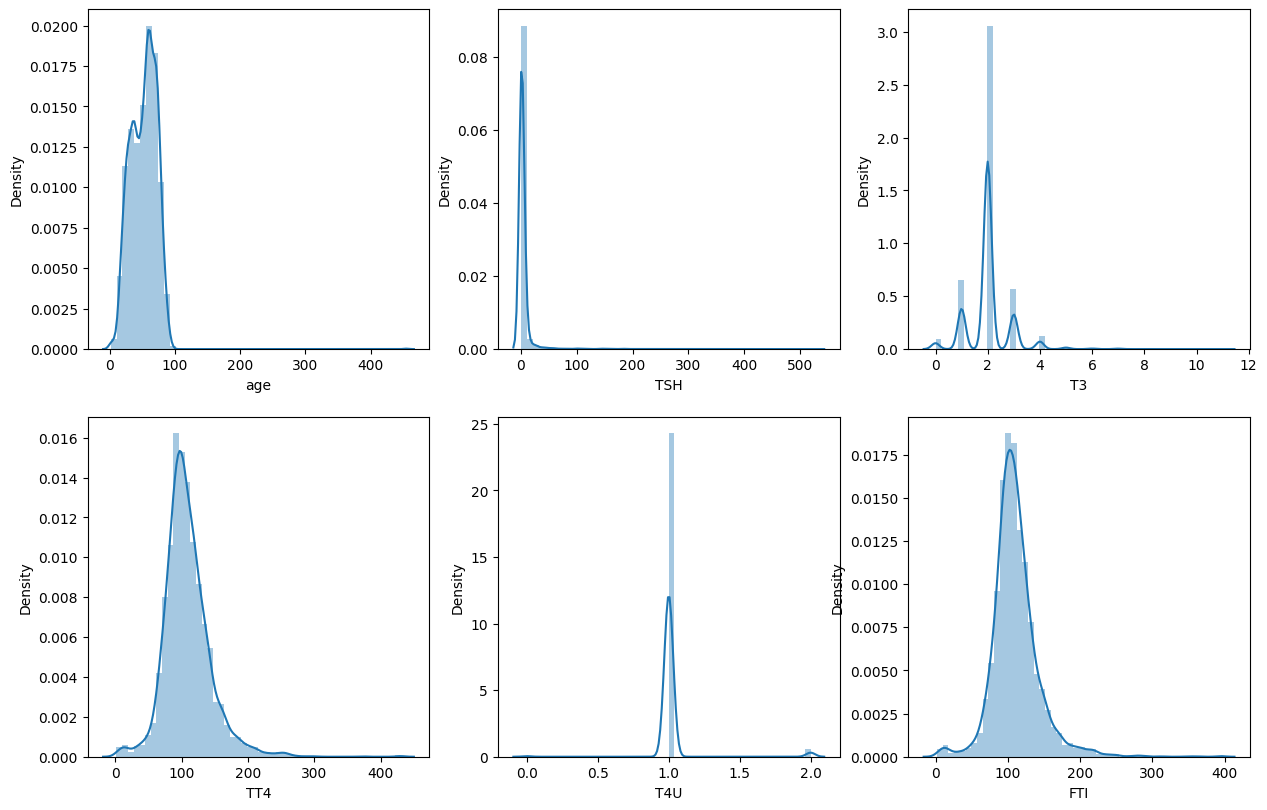

In [38]:
## For checking the distribution for our continuous data in the dataset.


columns = ['age','TSH','T3','TT4','T4U','FTI']

plt.figure(figsize=(15,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plt.subplot(3,3,plotnumber)
    sns.distplot(new_data[column])
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

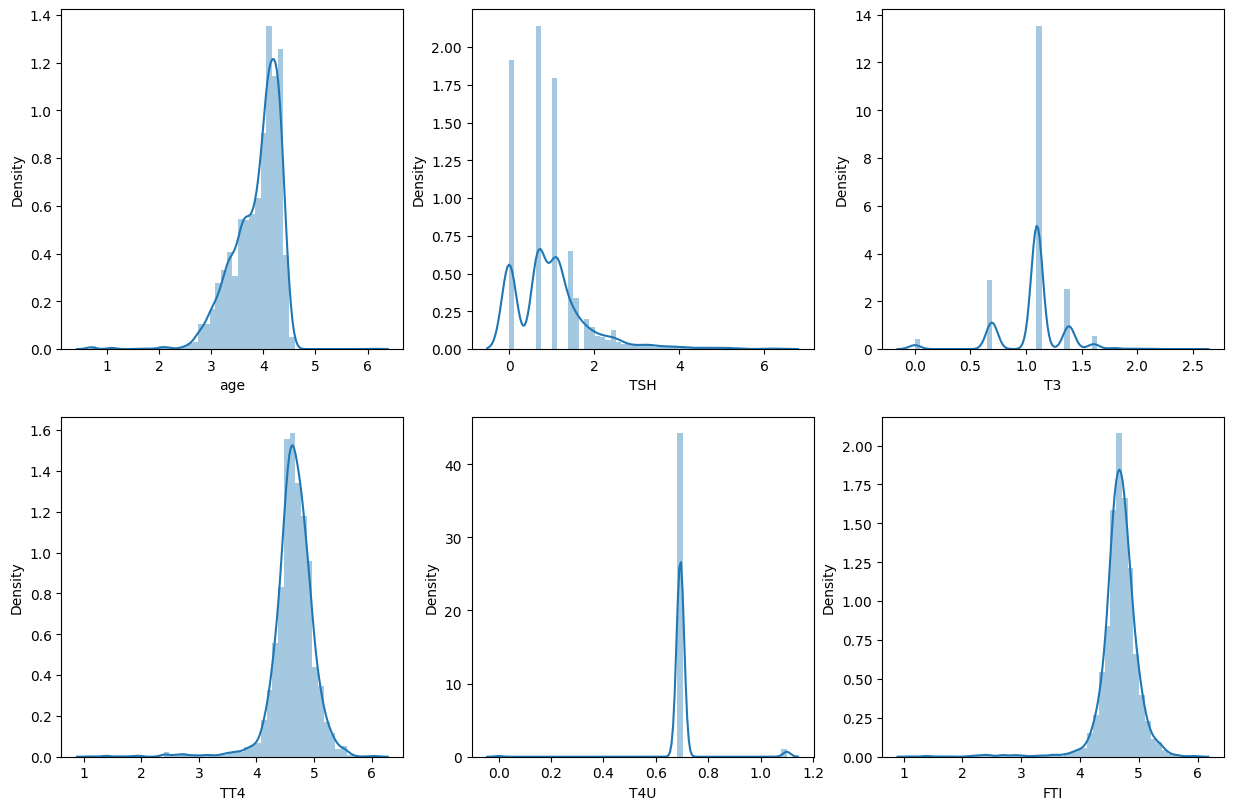

In [39]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plt.figure(figsize=(15,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_data[column]+=1
    ax = plt.subplot(3,3,plotnumber)
    sns.distplot(np.log(new_data[column]))
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

In [40]:
new_data = new_data.drop(['TSH'], axis = 1)

<Axes: xlabel='Class', ylabel='count'>

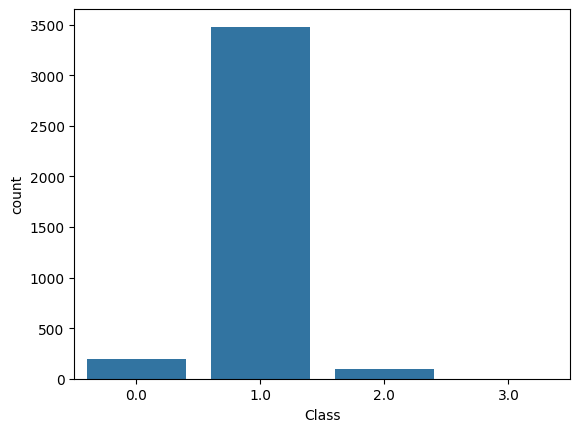

In [41]:
#countplot of class column to see the distribution
sns.countplot(data=new_data, x= 'Class')

In [42]:
x = new_data.drop(['Class'],axis=1)
y = new_data['Class']

In [45]:
#For balancing the imbalance dataset
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE
rdsample=RandomOverSampler()

rdsample = RandomOverSampler()
x_sampled, y_sampled = rdsample.fit_resample(x, y)


In [46]:
#Checking for shape of x_sample
x_sampled.shape

(13924, 24)

In [47]:
#creating dataframe of x_sample
x_sampled = pd.DataFrame(data = x_sampled, columns = x.columns)
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,1.0
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,1.0
13921,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,1.0
13922,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,1.0


<Axes: xlabel='Class', ylabel='count'>

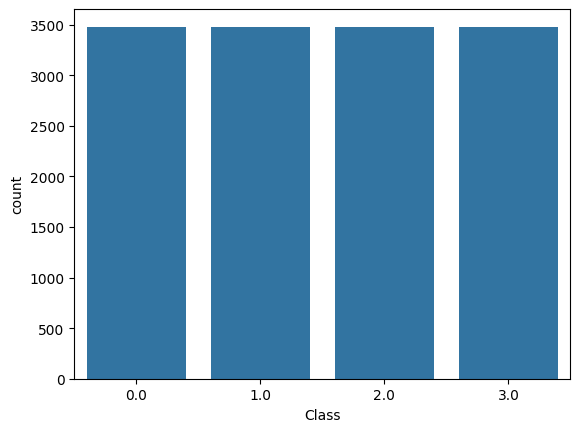

In [48]:
sns.countplot(data=new_data, x= y_sampled)

<Axes: >

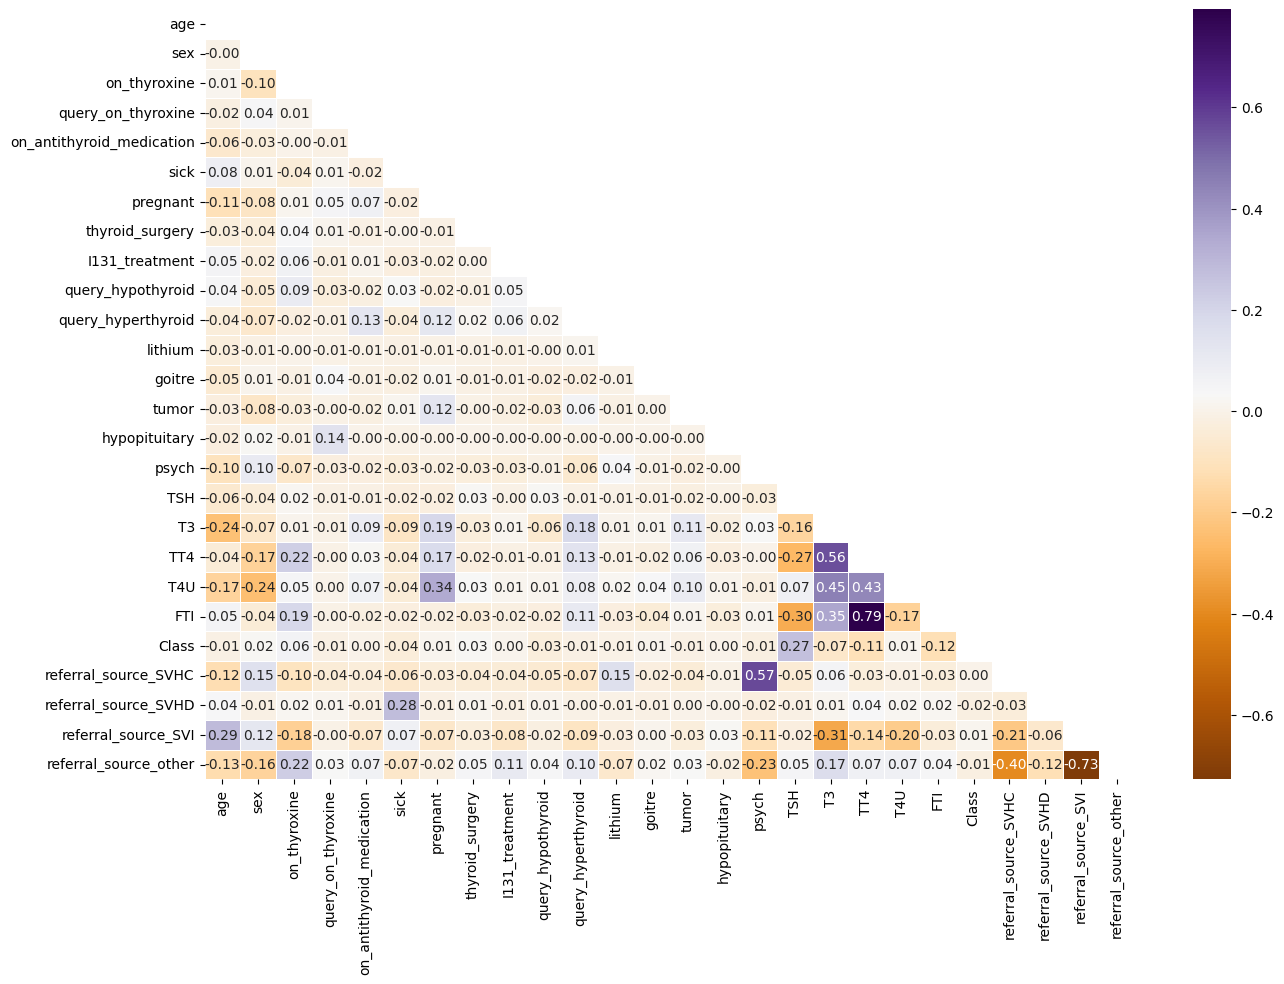

In [49]:
# Correlation Analysis Using Heatmap

plt.figure(figsize=(15, 10))
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data.corr(),mask= mask, annot=True, fmt='.2f', linewidths=0.5, cmap='PuOr')

In [50]:
#Splitting data into train and test for model building

X_train,X_test,y_train,y_test=train_test_split(x_sampled,y_sampled,test_size=0.2,random_state=0)

In [51]:
# Function to Create and Train ANN Models
def build_ann_model(layers, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for units in layers:
        model.add(Dense(units, activation=activation))
    model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output Layer
    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [52]:
# Define MLP Model
def mlp_classifier(X_train, X_test, y_train, y_test):
    mlp_model = build_ann_model([64, 32])
    mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
    return f'Accuracy_Score: {test_acc}\n Train Score: {mlp_model.evaluate(X_train, y_train)[1]}\n Test Score: {test_acc}'

In [53]:
# Define FNN Model
def fnn_classifier(X_train, X_test, y_train, y_test):
    fnn_model = build_ann_model([128, 64, 32])
    fnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    test_loss, test_acc = fnn_model.evaluate(X_test, y_test)
    return f'Accuracy_Score: {test_acc}\n Train Score: {fnn_model.evaluate(X_train, y_train)[1]}\n Test Score: {test_acc}'

In [54]:
# Define DNN Model
def dnn_classifier(X_train, X_test, y_train, y_test):
    dnn_model = build_ann_model([256, 128, 64, 32])
    dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    test_loss, test_acc = dnn_model.evaluate(X_test, y_test)
    return f'Accuracy_Score: {test_acc}\n Train Score: {dnn_model.evaluate(X_train, y_train)[1]}\n Test Score: {test_acc}'

In [60]:
# Define Autoencoder Model
def autoencoder_classifier(X_train, X_test, y_train, y_test):
    input_layer = Input(shape=(X_train.shape[1],))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)

    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')

    # Train Autoencoder
    autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, X_test))

    # Extract Encoder
    encoder = Model(input_layer, encoded)
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)

    # Define Classifier with Correct Input Shape (64 Features)
    classifier = Sequential([
        Input(shape=(64,)),  # Adjusted input shape
        Dense(32, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')  # Output layer
    ])

    classifier.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    # Train Classifier
    classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test_encoded, y_test))
    test_loss, test_acc = classifier.evaluate(X_test_encoded, y_test)

    return f'Accuracy_Score: {test_acc}\n Train Score: {classifier.evaluate(X_train_encoded, y_train)[1]}\n Test Score: {test_acc}'


In [56]:
# Define Different ANN Models
models = {
    "MLP": build_ann_model([64, 32]),
    "FNN": build_ann_model([128, 64, 32]),
    "DNN": build_ann_model([256, 128, 64, 32]),
    "Autoencoder": autoencoder_classifier
}

In [58]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [63]:
def print_score(X_train, X_test, y_train, y_test):
    print("MLP:\n")
    result0=mlp_classifier(X_train, X_test, y_train, y_test)
    print(result0)
    print("-"*100)
    print()

    print("fnn:\n")
    result1=fnn_classifier(X_train, X_test, y_train, y_test)
    print(result1)
    print("-"*100)
    print()

    print("dnn:\n")
    result2=dnn_classifier(X_train, X_test, y_train, y_test)
    print(result2)

    print("-"*100)
    print()

    print("auto:\n")
    result4=autoencoder_classifier(X_train, X_test, y_train, y_test)
    print(result4)

    print("-"*100)
    print()
print_score(X_train, X_test, y_train, y_test)


MLP:

Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6161 - loss: 1.5103 - val_accuracy: 0.6851 - val_loss: 0.7143
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7323 - loss: 0.5593 - val_accuracy: 0.7864 - val_loss: 0.5007
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7654 - loss: 0.4992 - val_accuracy: 0.7278 - val_loss: 0.5760
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7787 - loss: 0.4641 - val_accuracy: 0.7957 - val_loss: 0.4551
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8084 - loss: 0.4093 - val_accuracy: 0.7487 - val_loss: 0.5413
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8142 - loss: 0.3941 - val_accuracy: 0.8320 - val_loss: 0.4133
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8159 - loss: 0.3819 - val_accuracy: 0.8147 - val_loss: 0.3784
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8257 - loss: 0.3697 - val_accura

In [65]:
mlp_pred = mlp_model.predict(X_test)
mlp_pred_labels = mlp_pred.argmax(axis=1)  # Convert probabilities to class labels

# Compute accuracy
mlp_accuracy = accuracy_score(y_test, mlp_pred_labels)
print(f'Accuracy Score: {mlp_accuracy}')

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy Score: 0.8333931777378815


In [103]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Attention, Add, Multiply, Concatenate, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define input shape (Assuming 20 features per patient)
input_shape = (20, 1)

# Input Layer
input_layer = Input(shape=input_shape)

# MLP Feature Extraction
x = Dense(64, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)

# LSTM Layer
lstm_out = LSTM(64, return_sequences=True)(x)

# Attention Mechanism
attention = Attention()([lstm_out, lstm_out])
attention_out = Add()([lstm_out, attention])
attention_out = Flatten()(attention_out)

# Fully Connected Layers
fc = Dense(64, activation='relu')(attention_out)
fc = Dropout(0.3)(fc)
fc = Dense(32, activation='relu')(fc)
fc = Dropout(0.3)(fc)

# Output Layer (Binary Classification: Healthy vs Thyroid Disease)
output_layer = Dense(1, activation='sigmoid')(fc)

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

# Dummy Data for Testing (Replace with actual dataset)
x_train = np.random.rand(1000, 20, 1)
y_train = np.random.randint(0, 2, 1000)

# Train Model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29            │ (None, 20, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_96 (Dense)          │ (None, 20, 64)         │            128 │ input_layer_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 20, 64)         │            256 │ dense_96[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_97 (Dense)          │ (None, 20, 32)         │          2,080 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 20, 32)         │            128 │ dense_97[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ (None, 20, 64)         │         24,832 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_5 (Attention)   │ (None, 20, 64)         │              0 │ lstm_15[0][0],         │
│                           │                        │                │ lstm_15[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 20, 64)         │              0 │ lstm_15[0][0],         │
│                           │                        │                │ attention_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 1280)           │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_98 (Dense)          │ (None, 64)             │         81,984 │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_45 (Dropout)      │ (None, 64)             │              0 │ dense_98[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_99 (Dense)          │ (None, 32)             │          2,080 │ dropout_45[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_46 (Dropout)      │ (None, 32)             │              0 │ dense_99[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 1)              │             33 │ dropout_46[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 111,521 (435.63 KB)

 Trainable params: 111,329 (434.88 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5087 - loss: 0.7023 - val_accuracy: 0.4800 - val_loss: 0.6934
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5445 - loss: 0.6955 - val_accuracy: 0.5350 - val_loss: 0.6906
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5172 - loss: 0.6992 - val_accuracy: 0.4650 - val_loss: 0.6956
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6067 - loss: 0.6729 - val_accuracy: 0.4650 - val_loss: 0.6978
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5848 - loss: 0.6696 - val_accuracy: 0.4750 - val_loss: 0.6948
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5922 - loss: 0.6731 - val_accuracy: 0.4650 - val_loss: 0.7007
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5977 - loss: 0.6590 - val_accuracy: 0.4650 - val_loss: 0.7000
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5789 - loss: 0.6796 - val_accuracy: 0.5000 - v

In [106]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Attention, Multiply, Add, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Example Dataset (Replace with actual dataset)
num_samples = 5000
timesteps = 100
features = 10
num_classes = 5

X = np.random.rand(num_samples, timesteps, features)  # Dummy feature data
y = np.random.randint(0, num_classes, size=(num_samples,))
y = to_categorical(y, num_classes)  # Convert labels to one-hot encoding

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Input layer
inputs = Input(shape=(timesteps, features))

# MLP feature extraction
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

# LSTM layer
lstm_out = LSTM(64, return_sequences=True)(x)

# Attention mechanism
attention = Attention()([lstm_out, lstm_out])
attention_out = Multiply()([attention, lstm_out])
context_vector = Add()([attention_out, lstm_out])

# Fully connected layers
x = Flatten()(context_vector)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Define model
model = Model(inputs, outputs)

# Compile model with optimized hyperparameters
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.2001 - loss: 1.6171 - val_accuracy: 0.1920 - val_loss: 1.6104
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.2011 - loss: 1.6096 - val_accuracy: 0.1990 - val_loss: 1.6098
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.2102 - loss: 1.6087 - val_accuracy: 0.1920 - val_loss: 1.6100
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.2050 - loss: 1.6095 - val_accuracy: 0.1920 - val_loss: 1.6111
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.2167 - loss: 1.6073 - val_accuracy: 0.1890 - val_loss: 1.6099
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.2207 - loss: 1.6073 - val_accuracy: 0.2100 - val_loss: 1.6102
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.2230 - loss: 1.6072 - val_accuracy: 0.1980 - val_loss: 1.6082
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.2170 - loss: 